# Paso 1: Lectura del Archivo de Texto

- Función: Abre un archivo de texto llamado enwiki-20240401-1.txt en modo de lectura
- Propósito: Leer todo el contenido del archivo y almacenarlo en la variable content para su posterior procesamiento.

In [4]:
with open("ArchivosWiki/enwiki-20240401-8.txt", "r") as file:
    content = file.read()
print(content)

[[The Buddha]]

CATEGORIES: Gautama Buddha, 5th-century BC Indian people, 5th century BC in religion, 5th-century BC philosophers, 6th-century BC Indian people, 6th-century BC Indian philosophers, Avatars of Vishnu, Buddhas, Classical humanists, Founders of religions, Indian ethicists, Indian political philosophers, Prophets in Ahmadiyya, Miracle workers, National heroes of Nepal, Philosophers of love, Philosophers of mind, Ascetics, Social philosophers, Year of birth unknown, Year of death unknown, Journey to the West characters, Seven Buddhas of the Past, Deified men

Siddhartha Gautama, most commonly referred to as the Buddha ('the awakened'), was a wandering ascetic and religious teacher who lived in South Asia during the 6th or 5th century BCE and founded Buddhism. According to Buddhist legends, he was born in Lumbini, in what is now Nepal, to royal parents of the Shakya clan, but renounced his home life to live as a wandering ascetic. Buddists believe that after leading a life of

# Paso 2: Funciones de Limpieza de Texto

In [5]:
import re
# Funciones de limpieza
def remove_newlines_and_whitespace(text):
     # Elimina nuevas líneas y reemplaza con espacio
    text = re.sub(r'[\r\n]+', ' ', text)
    # Convierte múltiples espacios a un solo espacio y elimina espacios en los extremos
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_unwanted_characters(text):
    # Elimina caracteres de puntuación y especiales
    text = re.sub(r'[^\w\s]', '', text)
    return text

def normalize_text(text):
     # Convierte el texto a minúsculas
    text = text.lower()
    return text

- remove_newlines_and_whitespace: Elimina saltos de línea y espacios en blanco adicionales, reemplazándolos por un solo espacio.
- remove_unwanted_characters: Elimina caracteres de puntuación y especiales.
- normalize_text: Convierte el texto a minúsculas.


# Paso 3: Aplicación de las Funciones de Limpieza


In [ ]:
import pandas as pd
# Aplicar funciones de limpieza en secuencia
cleaned_content = normalize_text(remove_unwanted_characters(remove_newlines_and_whitespace(content)))
#df = pd.DataFrame({'text': [remove_newlines(content)]})
# Crear el DataFrame de pandas
df = pd.DataFrame({'text': [cleaned_content]})
df.to_csv('processed.csv', index=False)
df.head()

,text
0,the buddha categories gautama buddha 5thcentur...


- Función: Aplica las funciones de limpieza al contenido del texto.
- Propósito: Crear un DataFrame de pandas con el texto limpio y guardarlo en un archivo CSV llamado processed.csv.

# Paso 4: Tokenización del Texto

- Función: Usa un tokenizer para convertir el texto en tokens y cuenta cuántos tokens hay en cada entrada del DataFrame.
- Propósito: Analizar la distribución de tokens en el texto, lo cual es útil para entender el tamaño y complejidad del texto.

<Axes: >

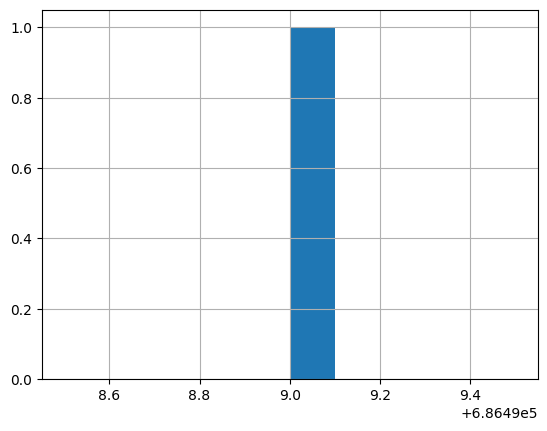

In [22]:
import tiktoken
import matplotlib
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv('processed.csv')
df.columns = ['text']
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

# Paso 5: División del Texto en Fragmentos
- Función: Divide el texto en fragmentos de un tamaño máximo de tokens.
- Propósito: Preparar el texto para su procesamiento en modelos de lenguaje, asegurando que cada fragmento sea manejable y no exceda la capacidad del modelo.

In [23]:
max_tokens = 150
# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):
    # Split the text into sentences
    sentences = text.split('.\n')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    chunks = []
    tokens_so_far = 0
    chunk = []
    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):
        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0
        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue
        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1
    return chunks
# shortened = []

# shortened = split_into_many(content)
shortened = []
# print(shortened)
# print(len(shortened))
for row in df.iterrows():
    if row[1]['text'] is None:
        continue
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(content)
    else:
        shortened.append(content)

- El propósito de este fragmento es analizar y visualizar la distribución del tamaño de los fragmentos de texto en términos de tokens. Esto es útil para entender cómo se distribuyen los datos y asegurarse de que los fragmentos no excedan el límite de tokens que puede manejar el modelo de lenguaje que se está utilizando. Además, esta información puede ser útil para ajustar el tamaño de los fragmentos si es necesario.

<Axes: >

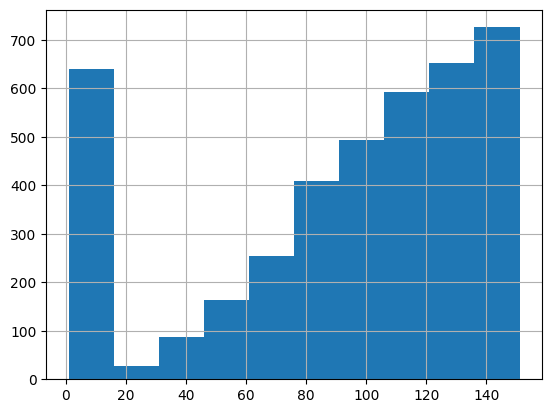

In [24]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

# Paso 6: Obtener Embeddings
- Función: Usa un modelo de embedding para convertir cada fragmento de texto en un vector de números.
- Propósito: Crear representaciones numéricas de los fragmentos de texto, lo cual es necesario para su uso en modelos de lenguaje.


In [25]:
from openai import OpenAI

client = OpenAI(
    api_key="",
)

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding


df['embeddings'] = df.text.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))
df.to_csv('embedings.csv', index=False)
df.head()

,text,n_tokens,embeddings
0,.,1,"[0.02592514455318451, 0.02510462887585163, 0.0..."
1,.,1,"[0.02592514455318451, 0.02510462887585163, 0.0..."
2,\nBuddhism spread beyond the Indian subcontine...,85,"[0.004416251555085182, -0.00802456121891737, 0..."
3,\nThe name of his clan was Gautama (Pali: Gota...,132,"[0.03612639755010605, -0.007155975326895714, 0..."
4,"\nShakyamuni (sa) means ""Sage of the Shakyas"".",18,"[0.008188129402697086, -0.028672238811850548, ..."


# Calcular Distancias y Crear Contexto para Preguntas
- Este fragmento de código está diseñado para cargar un archivo CSV que contiene embeddings de texto y prepararlos para su uso en cálculos de similitud. 
- El propósito de este fragmento es preparar los embeddings para cálculos de similitud. Al convertir los embeddings en arrays de numpy, puedes realizar operaciones matemáticas, como calcular la distancia coseno, para medir la similitud entre diferentes fragmentos de texto. Esto es crucial para tareas como encontrar el contexto más relevante para una pregunta, como se hace en el resto del código.

In [26]:
import numpy as np
from scipy.spatial.distance import cosine

df=pd.read_csv('embedings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()



,n_tokens,embeddings
text,,
.,1,"[0.02592514455318451, 0.02510462887585163, 0.0..."
.,1,"[0.02592514455318451, 0.02510462887585163, 0.0..."
"\nBuddhism spread beyond the Indian subcontinent, evolving into a variety of traditions and practices. The Buddha is recognized in other religious traditions, such as Hinduism, where he is considered an avatar of Vishnu. His legacy is not only encapsulated in religious institutions, but in the iconography and art inspired by his life and teachings, ranging from aniconic symbols to iconic depictions in various cultural styles.",85,"[0.004416251555085182, -0.00802456121891737, 0..."
"\nThe name of his clan was Gautama (Pali: Gotama). His given name, ""Siddhārtha"" (the Sanskrit form; the Pali rendering is ""Siddhattha""; in Tibetan it is ""Don grub""; in Chinese ""Xidaduo""; in Japanese ""Shiddatta/Shittatta""; in Korean ""Siltalta"") means ""He Who Achieves His Goal"". The clan name of Gautama means ""descendant of Gotama"", ""Gotama"" meaning ""one who has the most light"", and comes from the fact that Kshatriya clans adopted the names of their house priests.",132,"[0.03612639755010605, -0.007155975326895714, 0..."
"\nShakyamuni (sa) means ""Sage of the Shakyas"".",18,"[0.008188129402697086, -0.028672238811850548, ..."


# Paso 7: Crear Contexto para Preguntas
- Función: Encuentra el fragmento de texto más similar al texto de la pregunta.
- Propósito: Proporcionar contexto relevante para la pregunta, lo cual es crucial para obtener respuestas precisas.


In [27]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    q_embeddings = get_embedding(question)
    # q_embeddings = client.embeddings.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    # Get the distances from the embeddings
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))

    returns = []
    cur_len = 0
    
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(str(i))
    return ", ".join(returns)


# Paso 8: Responder Preguntas
- Función: Usa un modelo de lenguaje para responder a la pregunta utilizando el contexto encontrado.
- Propósito: Proporcionar una respuesta precisa y relevante a la pregunta basada en el contexto.


In [2]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=500,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Contexto:\n")
        print(context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Responde la pregunta basandote en el contexto, hazlo de manera clara. Si no puedes reponder basado en el contexto, solamente di 'Escribe AGENTE para más información.'"},
                {"role": "system", "content": f"contexto: {context}"},
                {"role": "user", "content": f"pregunta: {question}"},
                {"role": "assistant", "content": "respuesta:"}
                # {"role": "user", f"content": "Contexto: {context}\n\n---\n\nPregunta: {question}\nRespuesta:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

# Paso 9: Pruebas

In [29]:
answer_question(df, question="What are the main themes?", max_tokens=100)

'Los temas principales incluyen la exploración de la humanidad a través de la incertidumbre, la empatía, la identidad y la naturaleza humana en Blade Runner, así como la influencia bíblica en Beowulf.'

In [13]:
answer_question(df, question="What does it say about nature?")

'Nature is described in the context as having three qualities (sattva, rajas, and tamas) in Vedic philosophy. Additionally, it is mentioned that in nature, one form of life must always prey upon another, but human consciousness can hold an awareness of, and sympathy for, the will of other beings to live.'

In [28]:
answer_question(df, question="What does it say about the economy?", max_tokens=100)

'El texto menciona que Albania ha tenido éxito en la transición de una economía planificada socialista a una economía mixta capitalista. Se clasifica como una economía de ingresos medios altos por el Banco Mundial y en 2016 tenía la cuarta tasa de desempleo más baja en los Balcanes. Sus principales socios comerciales son Italia, Grecia, China, España, Kosovo y Estados Unidos. La moneda del país'

In [29]:
answer_question(df, question="Are you talking about economics?", max_tokens=100)

'Sí, se está hablando sobre temas relacionados con la economía en el contexto proporcionado.'

In [30]:
answer_question(df, question="What is the atomic number", max_tokens=100)

'El número atómico es el número de carga nuclear de un elemento químico, es decir, es igual al número de protones que se encuentran en el núcleo de cada átomo de ese elemento. También se puede utilizar para identificar de manera única los elementos químicos ordinarios.'

# LECTURA DE LOS ARCHIVOS GENERADOS

In [1]:
import os
import pandas as pd
import numpy as np
from openai import OpenAI
from scipy.spatial.distance import cosine

# Configura tu clave de API de OpenAI
client = OpenAI(
    api_key="",
)

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    q_embeddings = get_embedding(question)
    # q_embeddings = client.embeddings.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    # Get the distances from the embeddings
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))

    returns = []
    cur_len = 0
    
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(str(i))
    return ", ".join(returns)


def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="",
    max_len=500,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Contexto:\n")
        print(context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Responde la pregunta basandote en el contexto, hazlo de manera clara. Si no puedes reponder basado en el contexto, solamente di 'Escribe AGENTE para más información.'"},
                {"role": "system", "content": f"contexto: {context}"},
                {"role": "user", "content": f"pregunta: {question}"},
                {"role": "assistant", "content": "respuesta:"}
                # {"role": "user", f"content": "Contexto: {context}\n\n---\n\nPregunta: {question}\nRespuesta:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

# Leer todos los archivos CSV y concatenarlos en un solo DataFrame
directory = 'ResultEmbeddings'
all_embeddings = []
full_df = pd.DataFrame()

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        if 'embeddings' in df.columns:
            df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
            all_embeddings.append(df)
        else:
            print(f"'embeddings' column not found in {filename}")

if all_embeddings:
    full_df = pd.concat(all_embeddings, ignore_index=True)
else:
    full_df = pd.DataFrame()

answer_question(full_df, question="What are the main themes?", max_tokens=100)

'Escribe AGENTE para más información.'

In [ ]:
#full_df['embeddings'] = full_df.text.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))

In [4]:
answer_question(full_df, question="¿Quién pintó la Mona Lisa?")

'Leonardo da Vinci.'

In [5]:
answer_question(full_df, question="¿Cuál es la capital de Francia?")

'La capital de Francia es París.'

In [6]:

answer_question(full_df, question="¿Cuándo comenzó la Segunda Guerra Mundial?")

'Escribe AGENTE para más información.'

In [2]:
print(full_df.head())
full_df.head()

                                                text  n_tokens  \
0  [[AIM (software)]]\n\nCATEGORIES: 1997 softwar...       144   
1  \nAIM was popular by the late 1990s, in United...       150   
2  \nIn June 2015, AOL was acquired by Verizon Co...        53   
3  \n==History==\n\nIn May 1997, AIM was released...       115   
4  \nDuring its heyday, its main competitors were...       120   

                                          embeddings  distances  
0  [0.008112572133541107, -0.013291715644299984, ...   0.885002  
1  [0.038160696625709534, -0.006582450587302446, ...   0.854775  
2  [0.028669197112321854, -0.037410952150821686, ...   0.931589  
3  [0.02951241098344326, -0.01395278237760067, 0....   0.904801  
4  [0.011332163587212563, -0.04812916740775108, 0...   0.854939  


,text,n_tokens,embeddings,distances
0,[[AIM (software)]]\n\nCATEGORIES: 1997 softwar...,144,"[0.008112572133541107, -0.013291715644299984, ...",0.885002
1,"\nAIM was popular by the late 1990s, in United...",150,"[0.038160696625709534, -0.006582450587302446, ...",0.854775
2,"\nIn June 2015, AOL was acquired by Verizon Co...",53,"[0.028669197112321854, -0.037410952150821686, ...",0.931589
3,"\n==History==\n\nIn May 1997, AIM was released...",115,"[0.02951241098344326, -0.01395278237760067, 0....",0.904801
4,"\nDuring its heyday, its main competitors were...",120,"[0.011332163587212563, -0.04812916740775108, 0...",0.854939
